In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def diffuse_agents(x, y, d, L):
    """
    Moves agents on the lattice based on diffusion probability.

    Parameters
    ----------
    x, y : Agents' positions.
    d : Diffusion probability.
    L : Side length of the lattice.

    Returns
    -------
    x, y : Updated positions.
    """
    N = np.size(x)
    diffuse = np.random.rand(N)
    move = np.random.randint(4, size=N)
    for i in range(N):
        if diffuse[i] < d:
            if move[i] == 0:
                x[i] = x[i] - 1
            elif move[i] == 1:
                y[i] = y[i] - 1
            elif move[i] == 2:
                x[i] = x[i] + 1
            else:
                y[i] = y[i] + 1

    # Enforce periodic boundary conditions.
    x = x % L
    y = y % L

    return x, y

In [39]:
def update_opinions(x, y, opinions, influencer_flags, media_flags, age_groups, mu, attraction, deattraction, L, influence_radius, media_radius, noise_levels):
    """
    Updates agents' opinions based on interactions.

    Parameters
    ----------
    x, y : Agents' positions.
    opinions : Agents' opinions.
    influencer_flags : Boolean array indicating influencer agents.
    mu : Convergence parameter.
    attraction : Confidence bound.
    L : Side length of the lattice.
    influence_radius : Radius of influence for influencer agents.

    Returns
    -------
    opinions : Updated opinions.
    """
    N = np.size(x)
    # Create a grid to map agents to their positions for efficient lookup
    position_dict = {}
    for i in range(N):
        pos = (x[i], y[i])
        if pos in position_dict:
            position_dict[pos].append(i)
        else:
            position_dict[pos] = [i]
            
    # Define influence probabilities for each age group
    # Index 0 for young, 1 for old
    p_influencer = np.array([0.13, 0.07, 0.03, 0.01])  # Young, semi-young, semi-old, old
    p_nearby = np.array([0.29, 0.21, 0.11, 0.08])      # Young, semi-young, semi-old, old
    p_media = np.array([0.58, 0.72, 0.86, 0.91])       # Young, semi-young, semi-old, old

    # Interaction step
    for i in range(N):
        # Skip if influencer agent (they don't change their opinions)
        if influencer_flags[i]:
            continue

        if media_flags[i]:
            continue

        # Agents in the same cell
        same_cell_agents = position_dict[(x[i], y[i])]
        for j in same_cell_agents:
            if i != j:
                # Determine if agent i will be influenced by nearby agents
                if np.random.rand() < p_nearby[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinions towards each other
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinions away from each other
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)

        # Influencer agents within influence radius
        for j in np.where(influencer_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= influence_radius:
                # Determine if agent i will be influenced by influencers
                if np.random.rand() < p_influencer[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinion towards the influencer
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinion away from the influencer
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)
        # Media agents within media radius
        for j in np.where(media_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= media_radius:
                # Determine if agent i will be influenced by media
                if np.random.rand() < p_media[age_groups[i]]:
                    if abs(opinions[i] - opinions[j]) < attraction:
                        # Update opinion towards the media
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i + mu * (o_j - o_i)
                    elif abs(opinions[i] - opinions[j]) > deattraction:
                        # Update opinion away from the media
                        o_i = opinions[i]
                        o_j = opinions[j]
                        opinions[i] = o_i - mu * (o_j - o_i)
                    opinions[i] = np.clip(opinions[i], 0, 1)
    
    # Add age-dependent noise
    noise = np.random.normal(0, noise_levels[age_groups], size=N)
    opinions += noise
    opinions = np.clip(opinions, 0, 1)

    return opinions

In [40]:
def run_opinion_simulation(N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps, noise_levels):
    # Initialize agents' positions
    x = np.random.randint(L, size=N_part)
    y = np.random.randint(L, size=N_part)

    opinions = np.random.uniform(0.0, 1.0, N_part)

    # Assign age groups
    age_proportions = [0.10, 0.26, 0.30, 0.34]  #  young, semi-young, semi-old, old
    age_groups = np.random.choice(4, N_part, p=age_proportions) 

    # Generate a random permutation of indices
    indices = np.random.permutation(N_part)

    # Assign first N_influencers as influencers
    influencer_flags = np.zeros(N_part, dtype=bool)
    influencer_flags[indices[:N_influencers]] = True

    # Assign the next N_media as media agents
    media_flags = np.zeros(N_part, dtype=bool)
    media_flags[indices[N_influencers:N_influencers + N_media]] = True

    # Set media agents' opinions (e.g., neutral opinions)
    opinions[media_flags] = 0.4  # Media agents hold opinion 0.1

    # Set influencer agents' opinions (e.g., extreme opinions)
    opinions[influencer_flags] = 0.6  # Influencers hold opinion 0.9

    opinions_over_time = []
    for _ in range(max_steps):
        # Diffusion step
        x, y = diffuse_agents(x, y, d, L)

        # Update opinions
        opinions = update_opinions(
            x, y, opinions, influencer_flags, media_flags, age_groups,
            mu, attraction, deattraction, L, influence_radius, media_radius, noise_levels
        )

        opinions_over_time.append(opinions.copy())

    return opinions_over_time, influencer_flags, media_flags, age_groups


In [41]:
def simulate_and_plot(
    N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, 
    influence_radius, media_radius, max_steps, num_runs, noise_levels
):
    """
    Runs multiple simulations and plots the results.

    Parameters
    ----------
    N_part : Total number of agents (including influencers).
    N_influencers : Number of influencer agents.
    N_media : Number of media agents.
    L : Side length of the lattice.
    d : Diffusion probability.
    mu : Convergence parameter.
    attraction : Confidence bound.
    deattraction : Deattraction bound.
    influence_radius : Radius of influence for influencer agents.
    media_radius : Radius of influence for media agents.
    max_steps : Maximum number of time steps.
    num_runs : Number of independent runs.
    noise_levels : Noise levels for simulation.
    """
    for run in range(num_runs):
        opinions_over_time, influencer_flags, media_flags, age_groups = run_opinion_simulation(
            N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, 
            influence_radius, media_radius, max_steps, noise_levels
        )

        # Define the time steps to analyze
        time_steps = [0, int(len(opinions_over_time) / 4), int(len(opinions_over_time) / 2), len(opinions_over_time) - 1]
        
        colors = ['blue', 'green', 'orange', 'red']  # Different colors for each histogram
        
        for t in time_steps:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            # Plot for 18-29 agents
            axes[0, 0].hist(
                opinions_over_time[t][(age_groups == 0) & (~influencer_flags) & (~media_flags)],
                bins=20,
                alpha=0.7,
                color=colors[0]
            )
            axes[0, 0].set_title('18-29', fontsize=16)
            axes[0, 0].set_xlabel('Opinion', fontsize=12)
            axes[0, 0].tick_params(axis='both', which='major', labelsize=12)

            # Plot for 30-49 agents
            axes[0, 1].hist(
                opinions_over_time[t][(age_groups == 1) & (~influencer_flags) & (~media_flags)],
                bins=20,
                alpha=0.7,
                color=colors[1]
            )   
            axes[0, 1].set_title('30-49', fontsize=16)
            axes[0, 1].set_xlabel('Opinion', fontsize=12)
            axes[0, 1].tick_params(axis='both', which='major', labelsize=14)

            # Plot for 50-64 agents
            axes[1, 0].hist(
                opinions_over_time[t][(age_groups == 2) & (~influencer_flags) & (~media_flags)],
                bins=20,
                alpha=0.7,
                color=colors[2]
            )
            axes[1, 0].set_title('50-64', fontsize=16)
            axes[1, 0].set_xlabel('Opinion', fontsize=12)
            axes[1, 0].tick_params(axis='both', which='major', labelsize=14)

            # Plot for 65+ agents
            axes[1, 1].hist(
                opinions_over_time[t][(age_groups == 3) & (~influencer_flags) & (~media_flags)],
                bins=20,
                alpha=0.7,
                color=colors[3]
            )
            axes[1, 1].set_title('65+', fontsize=16)
            axes[1, 1].set_xlabel('Opinion', fontsize=12)
            axes[1, 1].tick_params(axis='both', which='major', labelsize=14)

            plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout
            plt.savefig(f'opinion_distribution_time_{t}_run_{run}.svg', format='svg')  # Save as SVG
            plt.show()  # Display the plot

        # New bar plot for proportions
        fig, ax = plt.subplots(figsize=(10, 6))
        age_group_names = ['18-29', '30-49', '50-64', '65+']
        below_half = [np.sum(opinions_over_time[t][age_groups == age_group] < 0.5) for age_group in range(4)]
        above_half = [np.sum(opinions_over_time[t][age_groups == age_group] >= 0.5) for age_group in range(4)]
        total = [below + above for below, above in zip(below_half, above_half)]

        proportions_below = [b / t if t > 0 else 0 for b, t in zip(below_half, total)]
        proportions_above = [a / t if t > 0 else 0 for a, t in zip(above_half, total)]

        bar_width = 0.35
        x = np.arange(len(age_group_names))

        ax.bar(x - bar_width / 2, proportions_below, bar_width, label='Opinions < 0.5', color='blue', alpha=0.7)
        ax.bar(x + bar_width / 2, proportions_above, bar_width, label='Opinions > 0.5', color='red', alpha=0.7)

        ax.set_title(f'Proportion of Opinions Below and Above 0.5 at Time {t}', fontsize=16)
        ax.set_xlabel('Age Groups', fontsize=14)
        ax.set_ylabel('Proportion', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(age_group_names, fontsize=12)
        ax.tick_params(axis='y', which='major', labelsize=12)

        # Move the legend outside the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, fontsize=12)

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        plt.savefig(f'opinion_proportions_time_{t}_run_{run}.svg', format='svg')  # Save as SVG
        plt.show()  # Display the plot

        # Plotting average opinion over time for different age groups
        young_opinions = []
        semi_young_opinions = []
        semi_old_opinions = []
        old_opinions = []
        for opinions in opinions_over_time:
            young_opinions.append(np.mean(opinions[age_groups == 0]))
            semi_young_opinions.append(np.mean(opinions[age_groups == 1]))
            semi_old_opinions.append(np.mean(opinions[age_groups == 2]))
            old_opinions.append(np.mean(opinions[age_groups == 3]))

        # Make the plot wider by increasing the width in figsize
        fig, ax = plt.subplots(figsize=(14, 5))  # Increased width from 10 to 14
        ax.plot(young_opinions, label='18-29', color=colors[0])
        ax.plot(semi_young_opinions, label='30-49', color=colors[1])
        ax.plot(semi_old_opinions, label='50-64', color=colors[2])
        ax.plot(old_opinions, label='65+', color=colors[3])

        # Set the x-axis limits to match the time steps
        ax.set_xlim(0, len(opinions_over_time) - 1)

        # Set text sizes
        ax.set_xlabel('Time Steps', fontsize=14)
        ax.set_ylabel('Average Opinion', fontsize=14)
        ax.set_title('Average Opinion Over Time for Different Age Groups', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Move the legend outside the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12, frameon=False)

        plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate the legend
        plt.savefig(f'average_opinion_over_time_run_{run}.svg', format='svg')  # Save as SVG
        plt.show()  # Display the plot


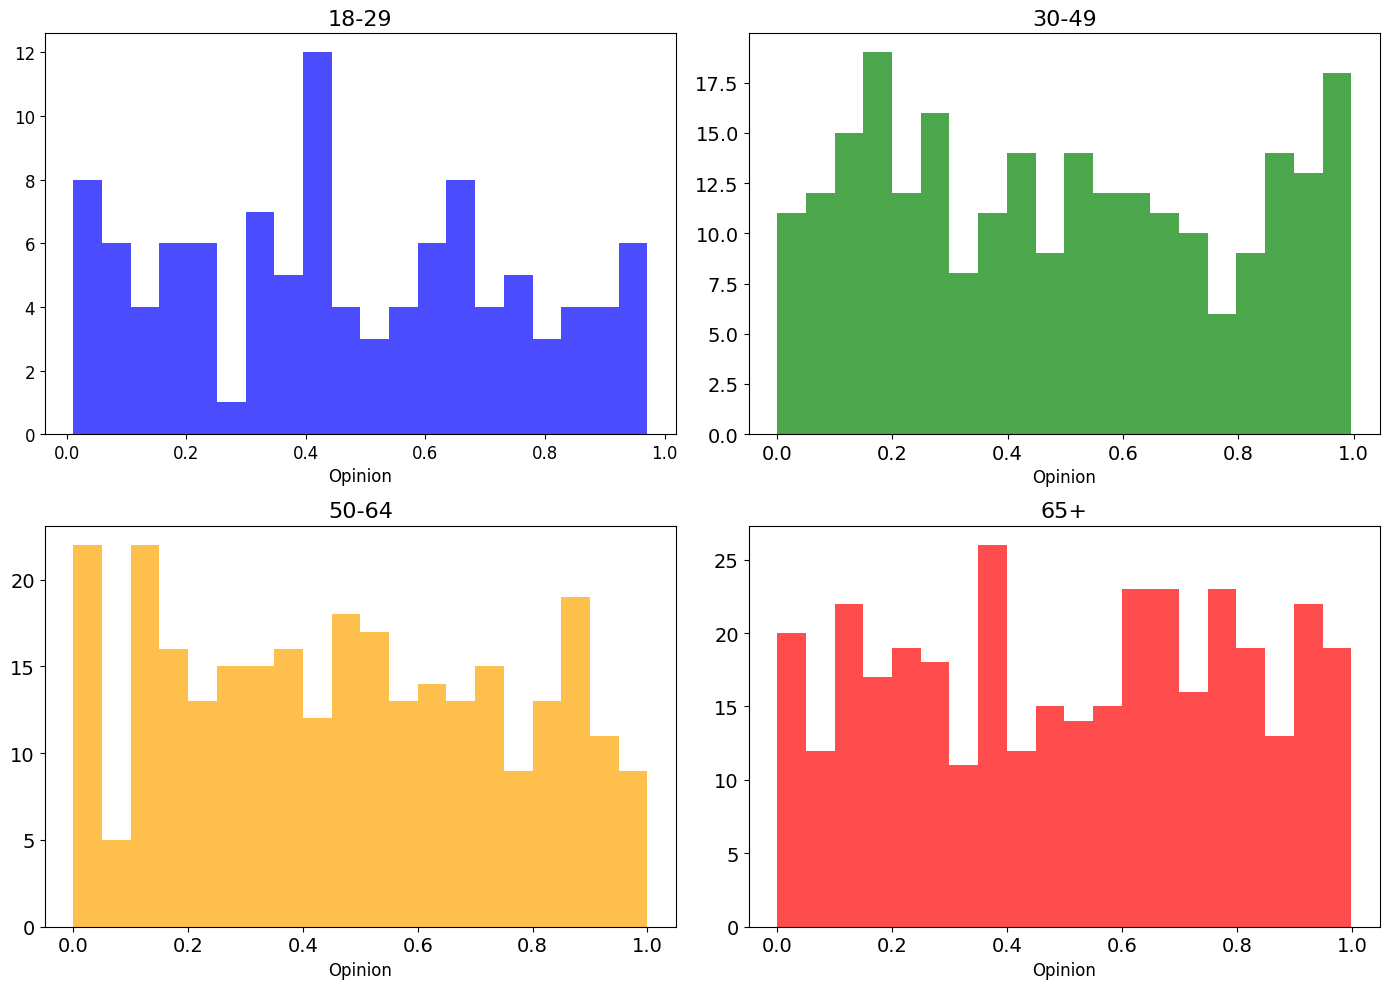

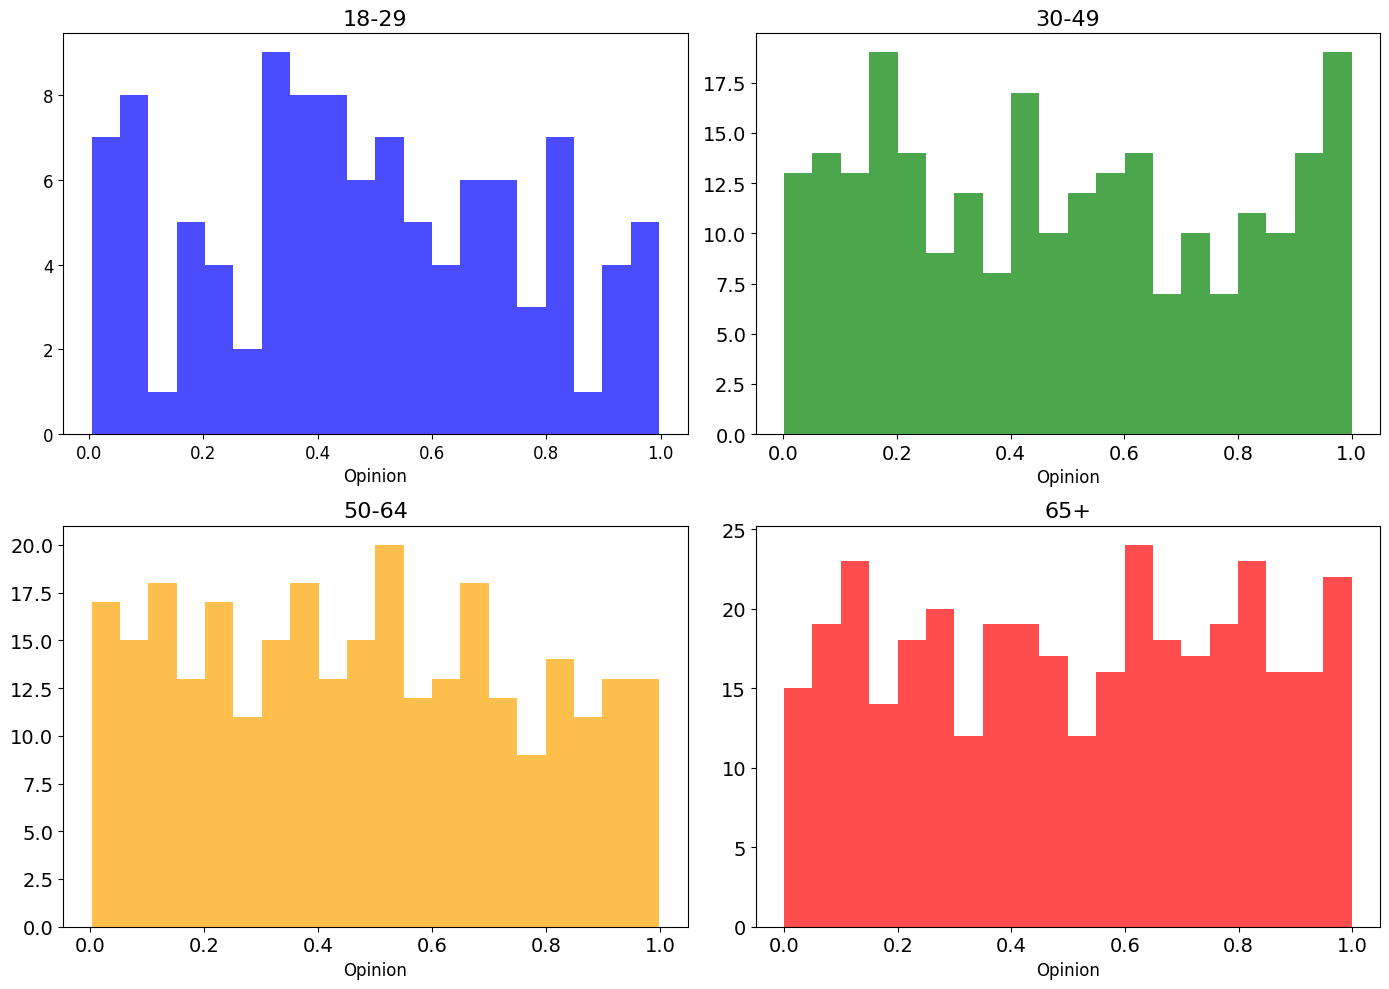

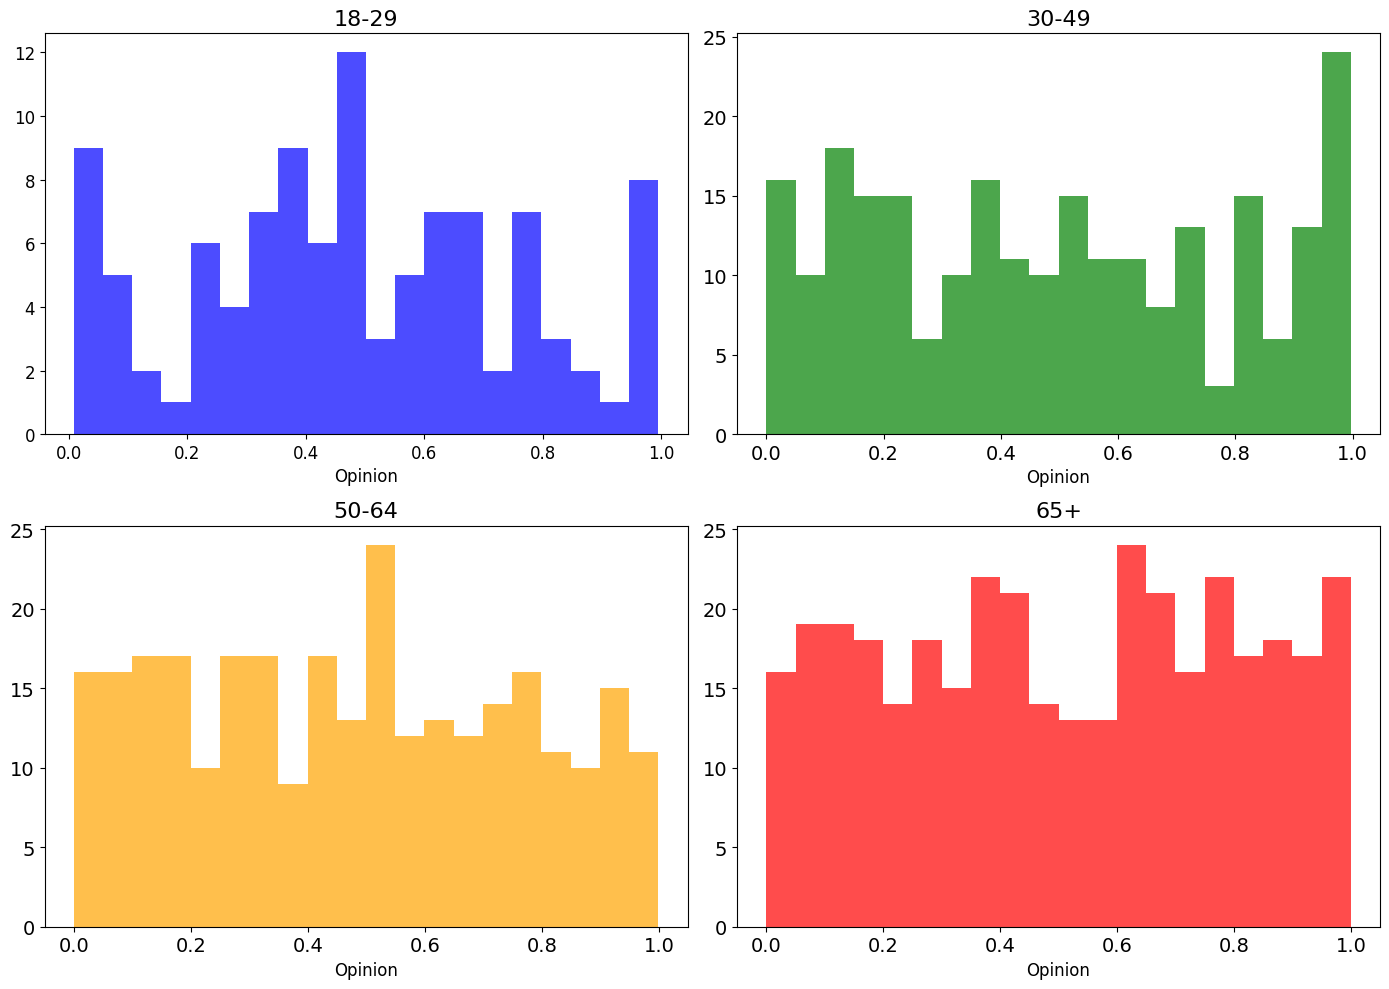

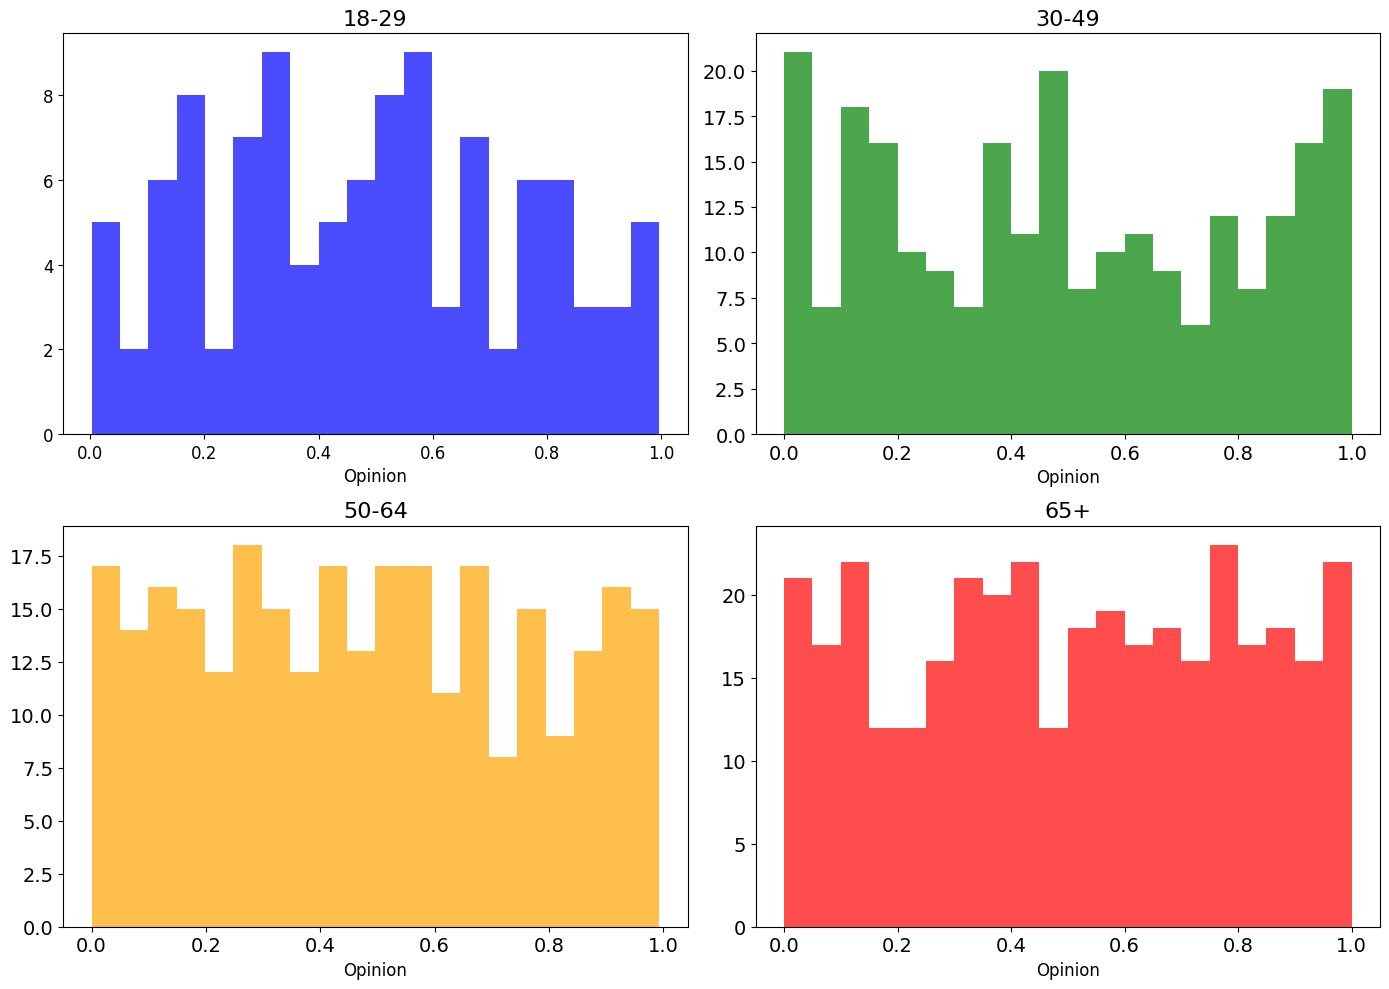

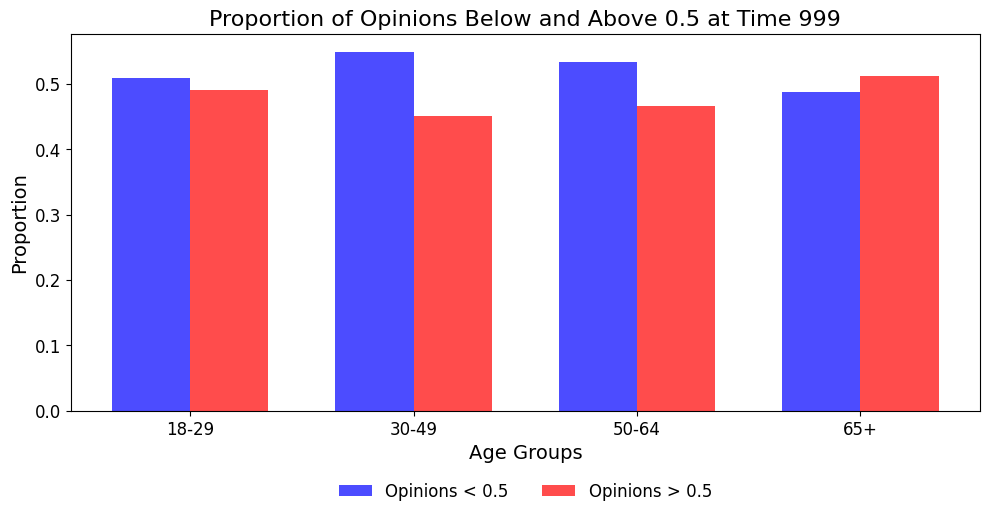

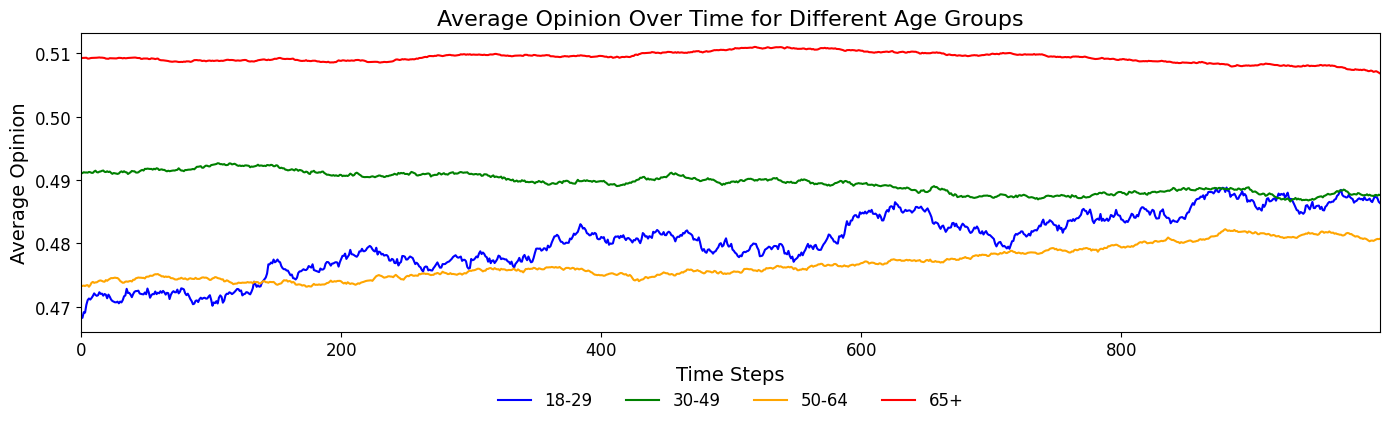

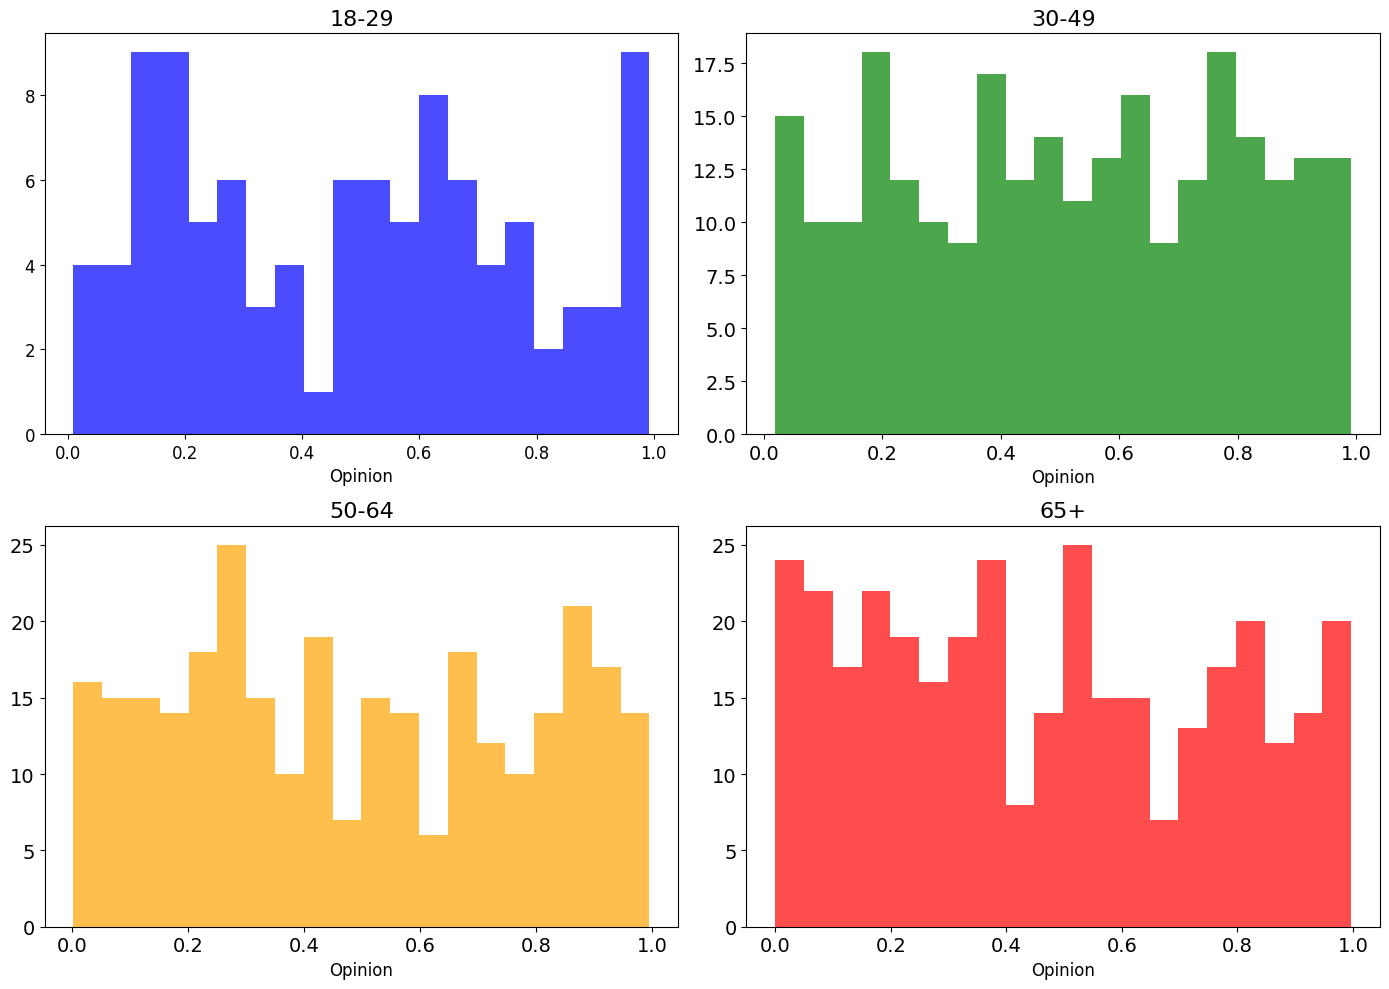

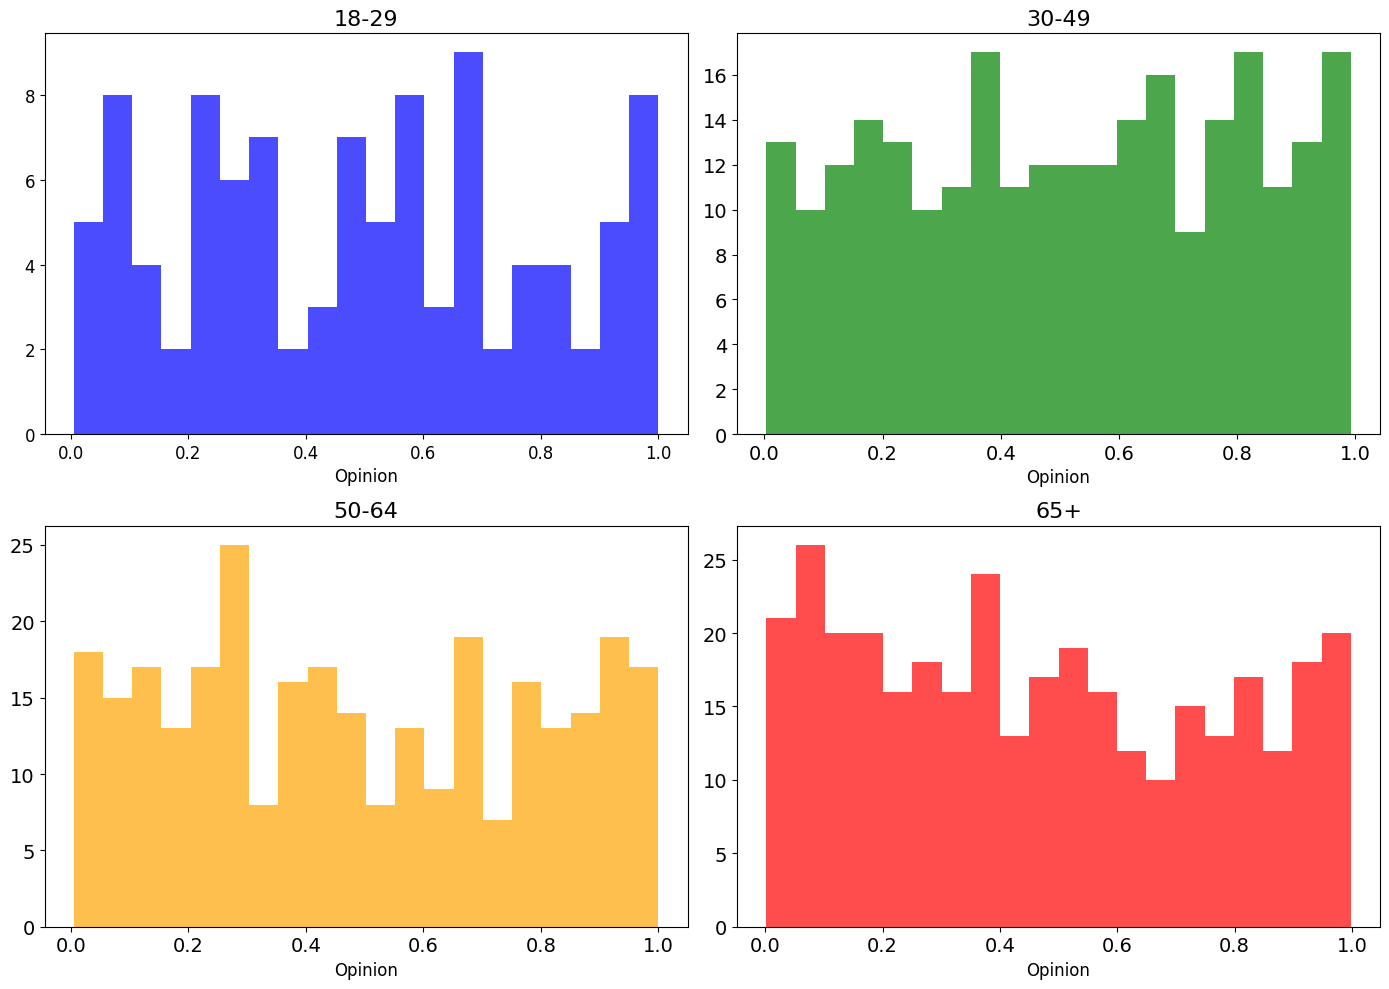

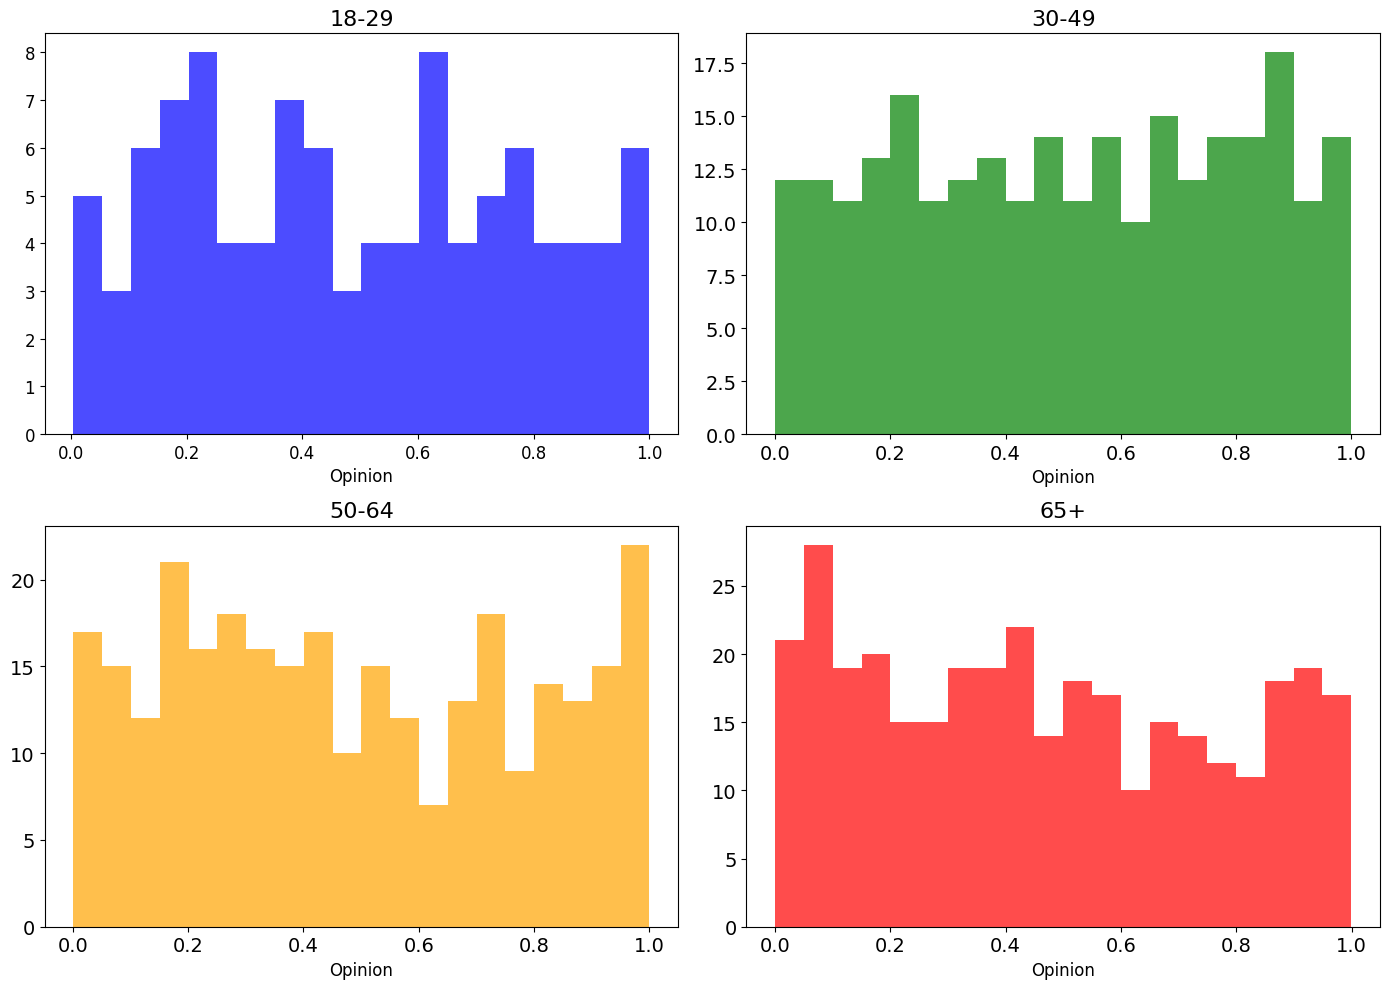

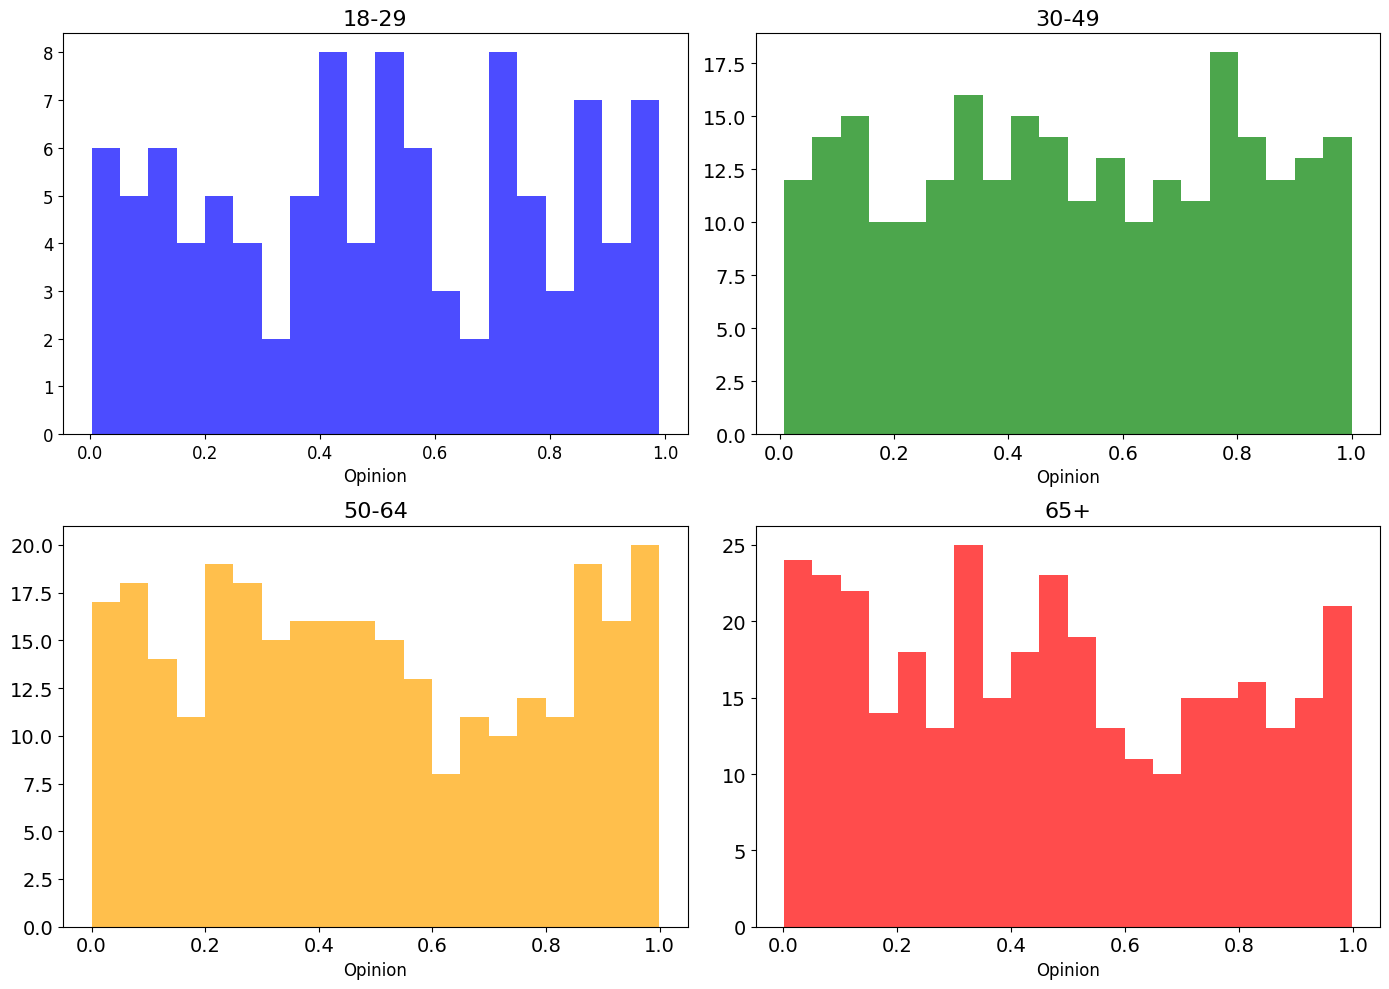

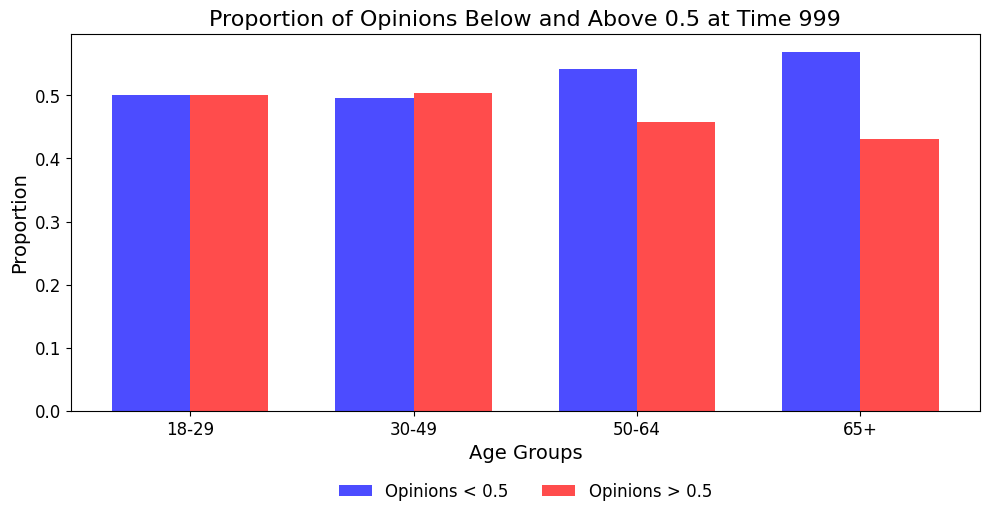

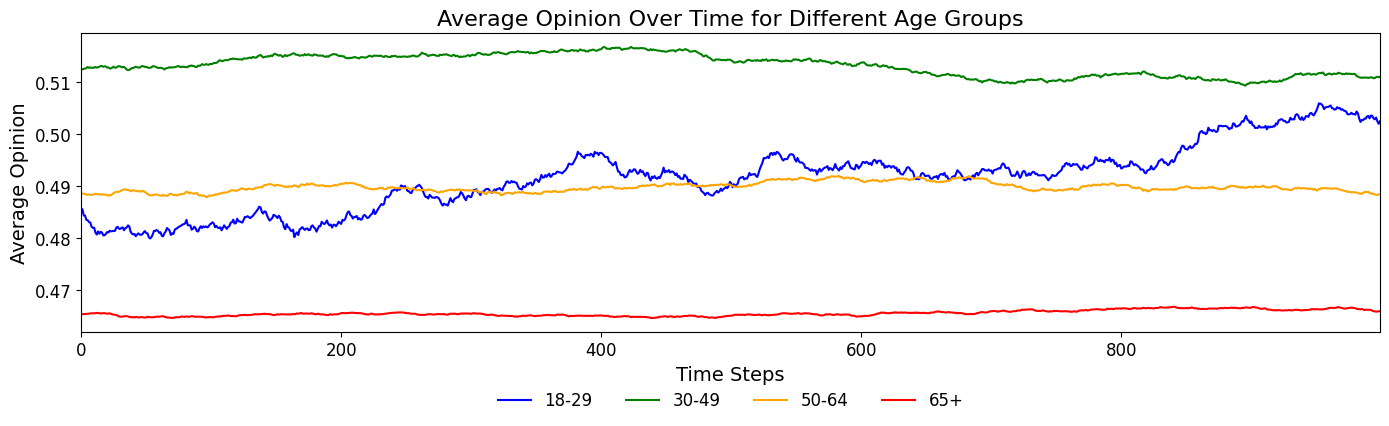

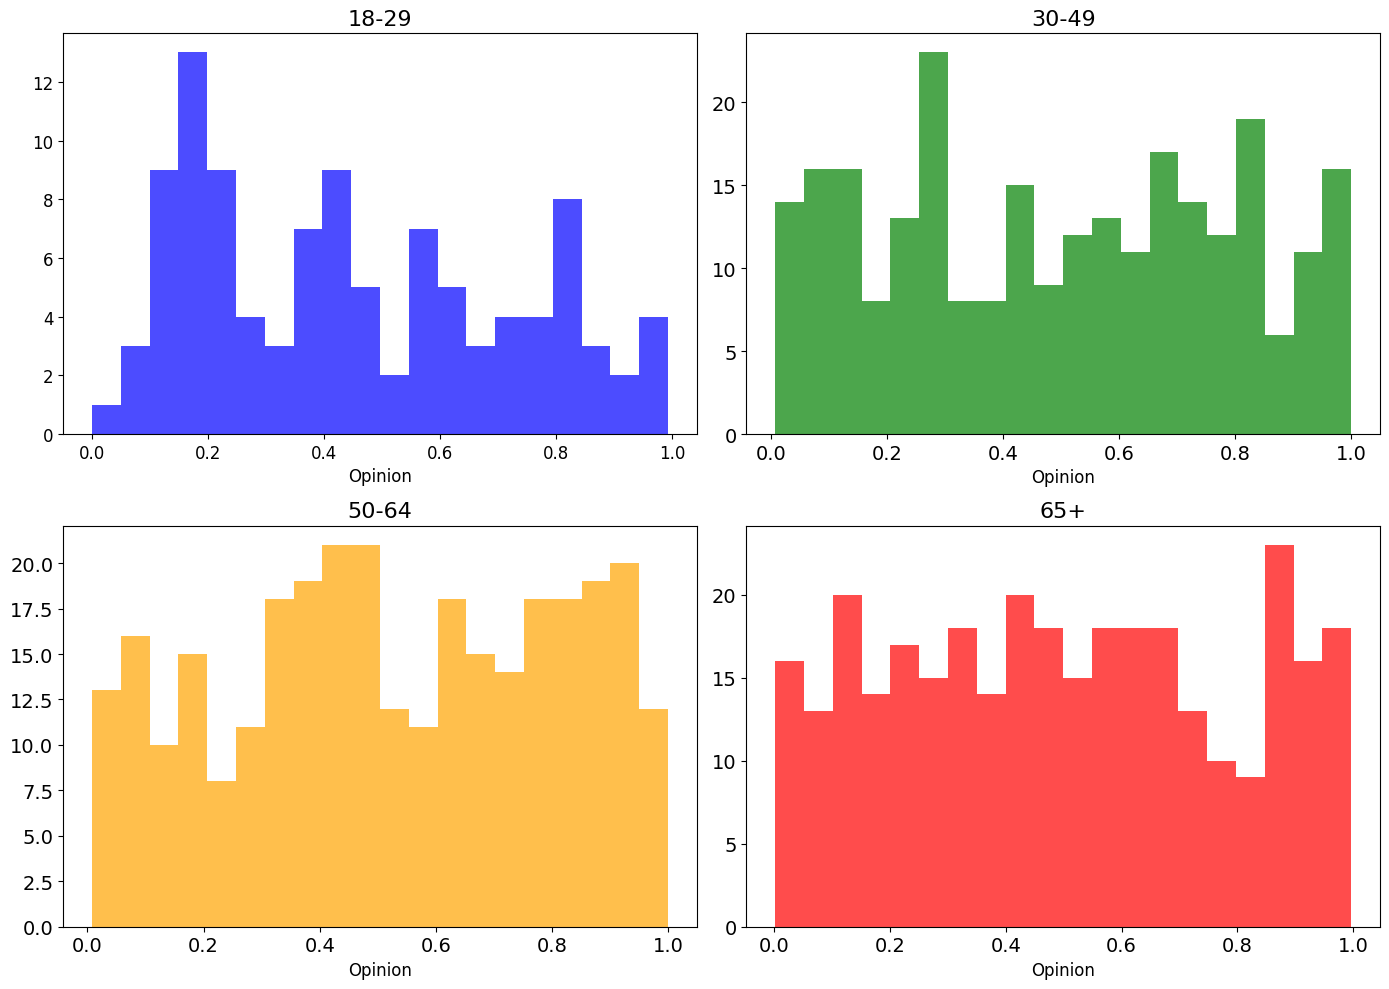

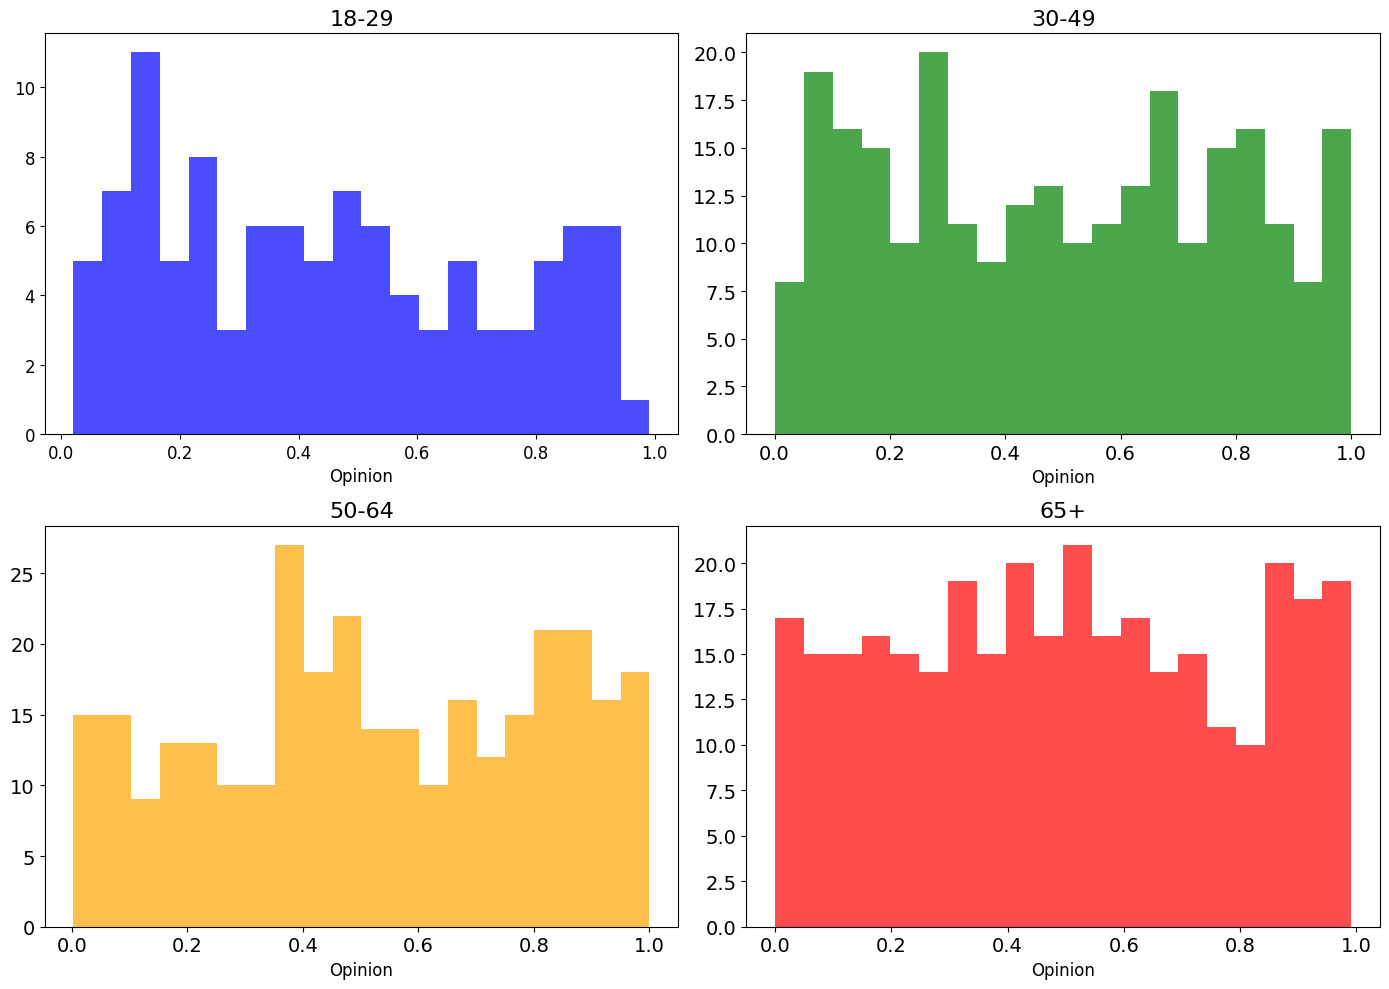

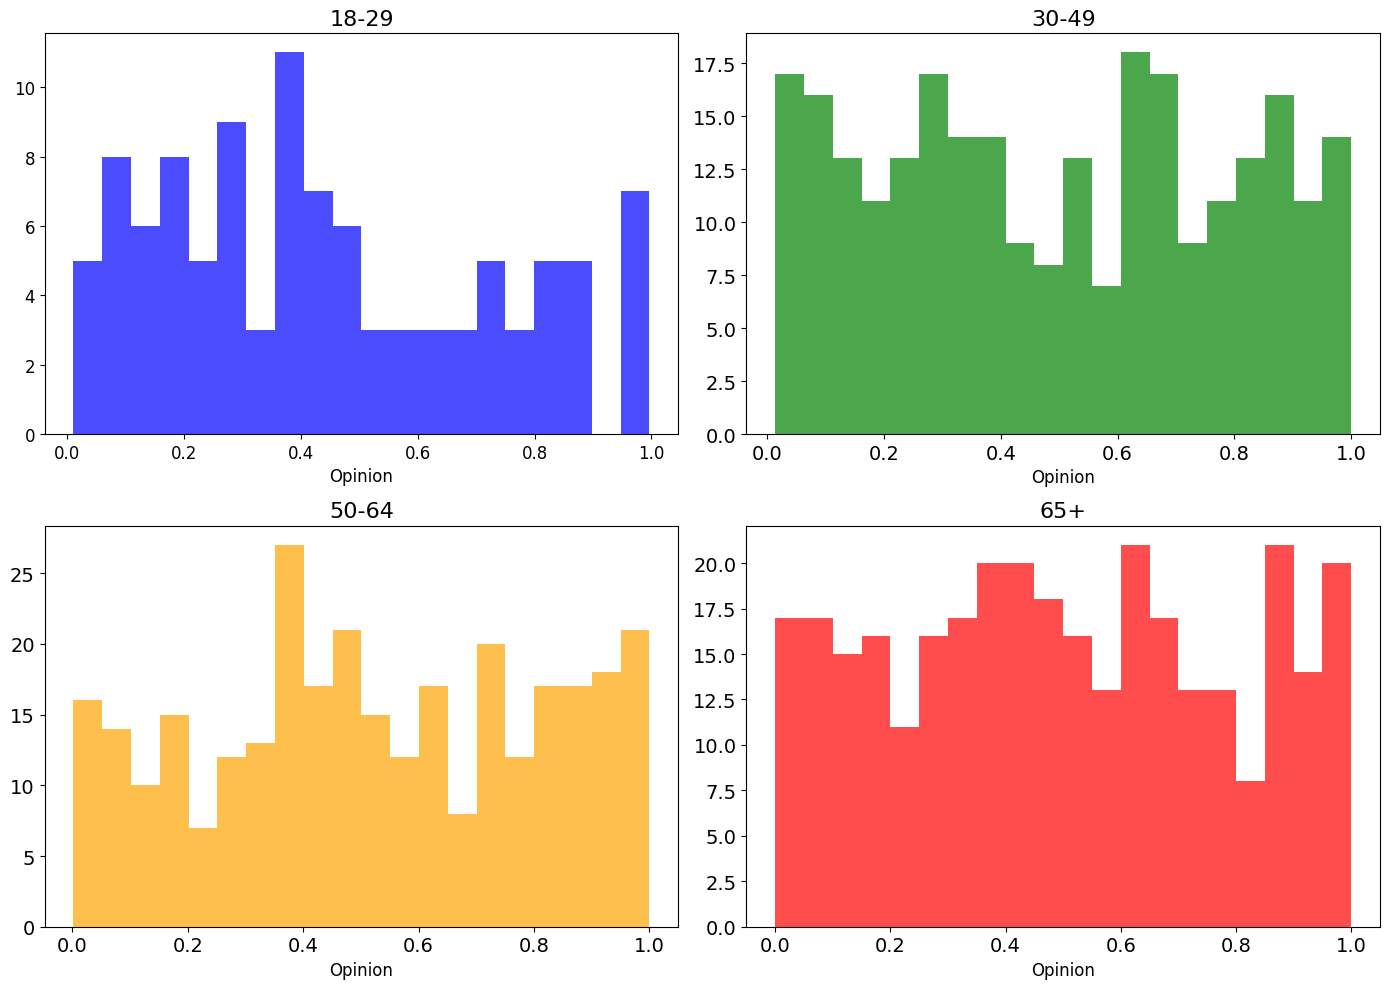

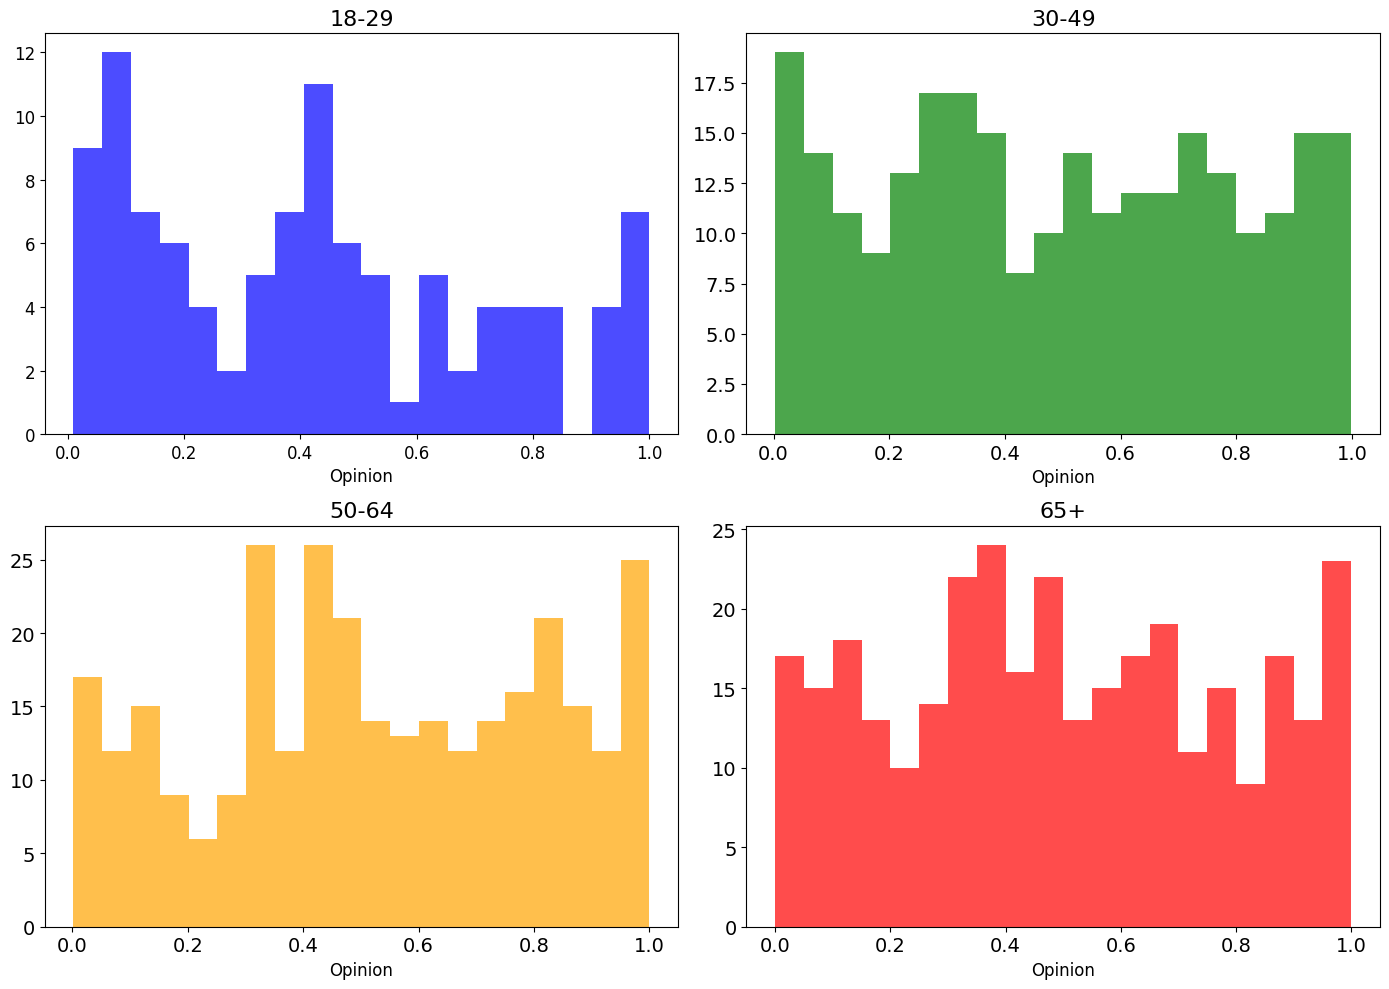

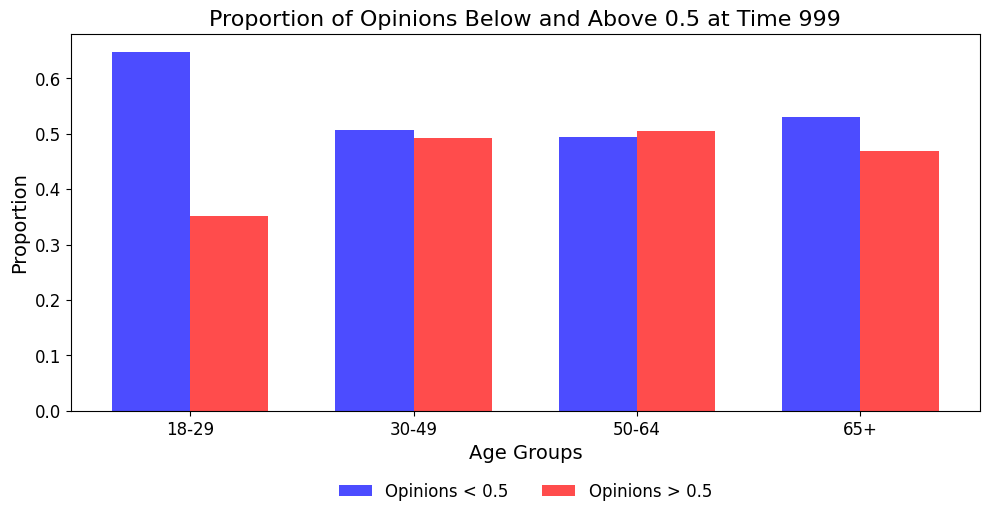

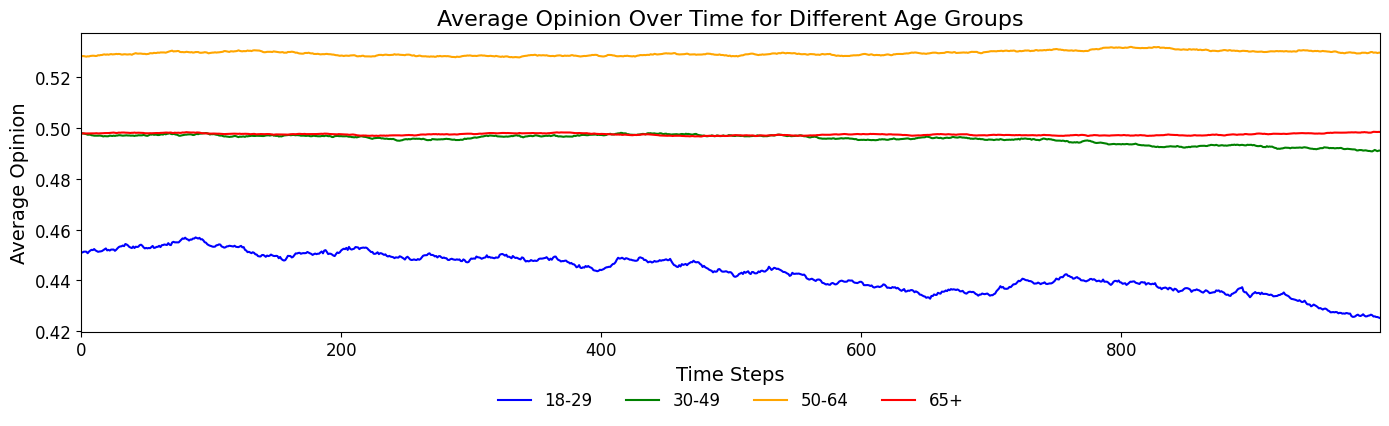

In [42]:
# Parameters
N_part = 1000        # Total number of agents (including influencers)
N_influencers = 1    # Number of influencer agents
N_media = 1          # Number of media agents
L = 50               # Side length of the lattice
d = 0.95             # Diffusion probability
mu = 0.001             # Convergence parameter
attraction = 0.2        # Confidence bound
deattraction = 0.6      # Deattraction bound
influence_radius = 10 # Influence radius for influencer agents
media_radius = 10     # Influence radius for media agents
max_steps = 1000     # Maximum number of time steps
num_runs = 3         # Number of independent runs
noise_levels = np.array([0.004, 0.002, 0.002, 0.001]) # Age-dependent noise levels (young, semi-young, semi-old, old)

simulate_and_plot(
    N_part, N_influencers, N_media, L, d, mu, attraction, deattraction ,influence_radius, media_radius,max_steps, num_runs, noise_levels
)

